In [1]:
import os,csv,re,sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
sys.path.insert(0, "/share/appspace_data/shared_groups/BGI/USERS/lichuanxiu/KDD/MMSRL-main")
from MMSRL.utils import *
from MMSRL.process import *
from MMSRL import train_model
import argparse

Loading MMSRL package...


In [2]:
# section_id = "14"
# k=6
# section_id = "4"
# k=5
#
section_id = "10"
k=7
# #
# section_id = "7"
# k=7

In [3]:
adata = sc.read_h5ad(os.path.join('/share/appspace_data/shared_groups/BGI/USERS/lichuanxiu/KDD/MMSRL-main/Data/chicken_heart/',
                                  "D"+section_id, "D" + section_id + '.h5ad'))

In [4]:
adata

AnnData object with n_obs × n_vars = 1916 × 24356
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'im_re'

In [5]:
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)  # avoiding all genes are zeros
# prefilter_specialgenes(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
adata =  adata[:, adata.var['highly_variable']]

In [6]:
coor_df = pd.read_csv(os.path.join('/share/appspace_data/shared_groups/BGI/USERS/lichuanxiu/KDD/MMSRL-main/Data/chicken_heart/D{}'
    '/D{}_tissue_positions_list.csv'.format(section_id,section_id),
         ), sep=",",header=None,na_filter=False, index_col=0)
adata.obs["array_row"] = coor_df[4]*-1
adata.obs["array_col"] = coor_df[5]
adata.obsm["spatial"] = coor_df.loc[adata.obs_names, [4,5]].to_numpy()

In [ ]:
lables_df = pd.read_csv("/share/appspace_data/shared_groups/BGI/USERS/lichuanxiu/KDD/MMSRL-main/Data/chicken_heart/D{}/D{}.csv".format(section_id,section_id), sep=",", header=0,
                      na_filter=False, index_col=0)
adata.obs['Ground Truth'] = lables_df.loc[adata.obs_names, "region"]
adata.obs['ground_truth'] = adata.obs['Ground Truth']

In [8]:
adata

AnnData object with n_obs × n_vars = 1916 × 3000
    obs: 'n_counts', 'array_row', 'array_col', 'Ground Truth', 'ground_truth'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'im_re', 'spatial'

In [ ]:
adata.obsm["adj"] = calculate_adj_matrix(adata)
adata= train_model.train(adata,k,n_epochs=200,h=[3000,3000],lr=0.00005,radius=0)

[2025-12-28 23:14:29] Epoch: 0/200, Loss: 15.1969
[2025-12-28 23:14:30] Epoch: 5/200, Loss: 13.8732
[2025-12-28 23:14:32] Epoch: 10/200, Loss: 12.7125
[2025-12-28 23:14:33] Epoch: 15/200, Loss: 10.4545
[2025-12-28 23:14:34] Epoch: 20/200, Loss: 9.0278
[2025-12-28 23:14:35] Epoch: 25/200, Loss: 8.3440
[2025-12-28 23:14:37] Epoch: 30/200, Loss: 7.9392
[2025-12-28 23:14:38] Epoch: 35/200, Loss: 7.6072
[2025-12-28 23:14:39] Epoch: 40/200, Loss: 7.3693
[2025-12-28 23:14:40] Epoch: 45/200, Loss: 7.1881
[2025-12-28 23:14:42] Epoch: 50/200, Loss: 7.0437
[2025-12-28 23:14:43] Epoch: 55/200, Loss: 6.9346
[2025-12-28 23:14:44] Epoch: 60/200, Loss: 6.8521
[2025-12-28 23:14:45] Epoch: 65/200, Loss: 6.7878
[2025-12-28 23:14:47] Epoch: 70/200, Loss: 6.8010
[2025-12-28 23:14:48] Epoch: 75/200, Loss: 6.6998
[2025-12-28 23:14:49] Epoch: 80/200, Loss: 6.6613
[2025-12-28 23:14:50] Epoch: 85/200, Loss: 6.6295
[2025-12-28 23:14:52] Epoch: 90/200, Loss: 6.5891
[2025-12-28 23:14:53] Epoch: 95/200, Loss: 6.616

In [ ]:
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['MMSRL'], obs_df['Ground Truth'])
print('Adjusted rand index = %.2f' % ARI)

Adjusted rand index = 0.69


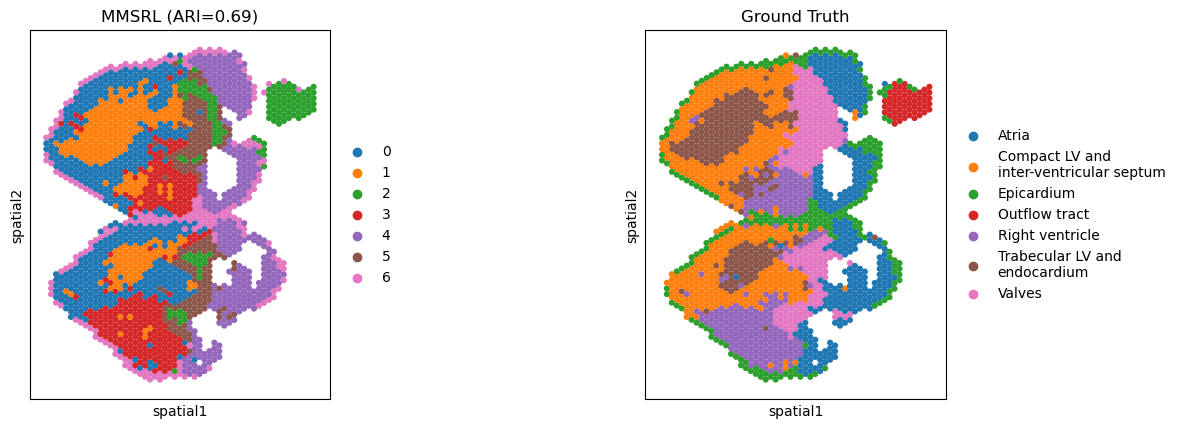

In [11]:
sc.pl.spatial(adata, color=["MMSRL", "Ground Truth"], title=['MMSRL (ARI=%.2f)' % ARI, "Ground Truth"],
           save=section_id, spot_size=300)


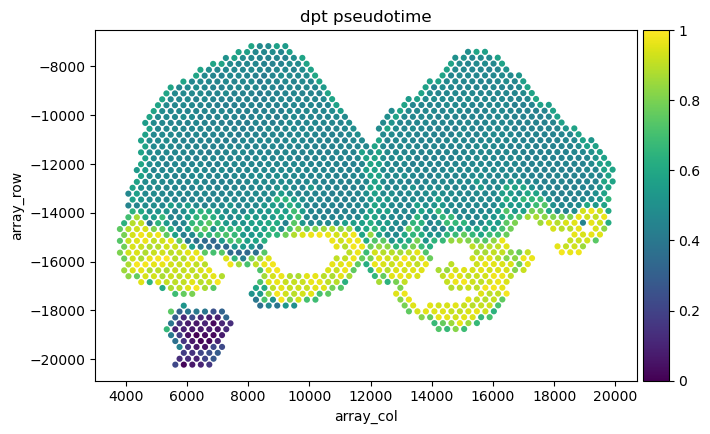

In [12]:
sc.pp.neighbors(adata, use_rep='emb_pca')
adata.uns['iroot'] = np.flatnonzero(adata.obs['MMSRL'] =="4")[0]  #D7

sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_branchings=1)
adata.obs['dpt_pseudotime'] =1-adata.obs['dpt_pseudotime']
sc.pl.scatter(adata, x="array_col", y="array_row", color='dpt_pseudotime', legend_fontsize=18, show=True,
                   size=150000 / adata.shape[0])
